# Compare to PE Network

## Preliminaries

In [393]:
# Imports
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [394]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

## Dataset

In [500]:
# Warp
def RandomSample():
    theta = ( np.random.rand()*2. - 1. ) * np.pi/8.
    rho = np.random.rand()*0.8 + 1.5
    y = np.array([rho-1.8, theta])
    x0 = rho*np.cos(theta) - 1.7
    x1 = rho*np.sin(theta)*0.5
    x = np.array([x0,x1])
    return [y, x]

In [501]:
n_samples = 500
training_input = []
training_output = []
for idx in range(n_samples):
    blah = RandomSample()
    training_input.append(np.array(blah[0]))
    training_output.append(np.array(blah[1]))
train = [np.array(training_input), np.array(training_output)]

testing_input = []
testing_output = []
for idx in range(n_samples):
    blah = RandomSample()
    testing_input.append(np.array(blah[0]))
    testing_output.append(np.array(blah[1]))
test = [np.array(testing_input), np.array(testing_output)]

train1 = [np.array(train[0])[:1,:], np.array(train[1])[:1,:]]

In [502]:
train1[0]

array([[-0.15672223, -0.22464579]])

In [503]:
train1[1]

array([[-0.09801275, -0.18302916]])

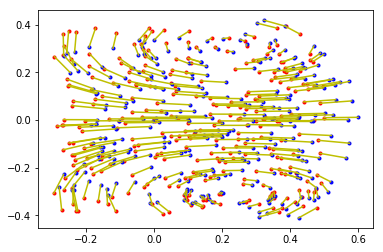

In [504]:
n = 300
plt.plot(test[0][:n,0], test[0][:n,1], 'r.');
plt.plot(test[1][:n,0], test[1][:n,1], 'b.');
for k in range(n):
    st = [test[0][k,0], test[1][k,0]]
    en = [test[0][k,1], test[1][k,1]]
    plt.plot(st, en, 'y')

In [505]:
Weights = [np.array([[ 0.63827171,  1.94878605],
        [-1.54809306, -1.08798682],
        [ 0.41531103,  0.40218358],
        [ 1.9545372 ,  0.84283361]]),
 np.array([[-0.142614  , -0.50655311,  0.44099561,  1.17943999],
        [ 1.43606398, -0.29175979,  0.3383928 , -0.4229459 ]])]
Biases = [np.array([ 0.72180323, -0.71274565]),
 np.array([-0.04621402, -0.40947562, -0.06824616,  0.54733387]),
 np.array([-0.58947249, -0.48776308])]

# Feed-Forward Network

## Create the Neural Network

In [627]:
import network as Network
net = Network.Network([2, 4, 2], type='regression')

In [628]:
net.W = deepcopy(Weights)
net.b = deepcopy(Biases)

In [629]:
net.W[0]

array([[ 0.63827171,  1.94878605],
       [-1.54809306, -1.08798682],
       [ 0.41531103,  0.40218358],
       [ 1.9545372 ,  0.84283361]])

## Train the Network

In [294]:
progress = net.SGD(train, epochs=400, lrate=0.1, batch_size=10)

A Jupyter Widget

In [516]:
net.FeedForward(train1[0][0])
net.BackProp_no_increment(train1[1][0])

In [640]:
net.FeedForward(np.array(x[1][1]))
net.BackProp_no_increment(train1[1][0])

In [641]:
print(train1[0][0])
print(net.h[0])
print(net.h[1])
print(net.h[-1])

[-0.15672223 -0.22464579]
[0.43314663 0.14592792]
[0.62589205 0.22464588 0.5424809  0.82008567]
[0.413945   0.18223507]


## Test the Network

In [370]:
y = []
for x,t in zip(test[0], test[1]):
    y.append(net.FeedForward(x))

y = np.array(y)

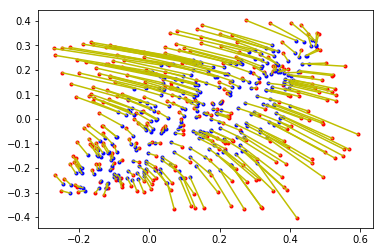

In [371]:
n = 300
plt.plot(test[1][:n,0], test[1][:n,1], 'r.');
plt.plot(y[:n,0], y[:n,1], 'b.');
for k in range(n):
    st = [test[1][k,0], y[k,0]]
    en = [test[1][k,1], y[k,1]]
    plt.plot(st, en, 'y')

# PE Network

In [664]:
# Preliminaries
import torch
dtype = torch.float
import NeuralNetwork as NN
import Layer
import importlib
import time
from copy import deepcopy
from IPython.display import display
from ipywidgets import FloatProgress

importlib.reload(NN)
importlib.reload(Layer);

## Create the Neural Network

In [665]:
pe_net = NN.NeuralNetwork()
pe_net.AddLayer(Layer.InputPELayer(n=2))
pe_net.ConnectNextLayer(Layer.PELayer(n=4))
pe_net.ConnectNextLayer(Layer.TopPELayer(n=2))
pe_net.layers[0].SetActivationFunction('identity')
pe_net.layers[1].SetActivationFunction('logistic')
pe_net.layers[2].SetActivationFunction('identity')
pe_net.SetTau(0.08)
pe_net.learn = True
pe_net.layers[1].Probe(False)

In [666]:
# Construct a PE network using the same weight matrices.
# But construct it upside-down, so that it projects top
# to bottom.
pe_net.connections[1].W = torch.tensor(deepcopy(Weights[0])).float()
pe_net.connections[1].M = torch.tensor(deepcopy(Weights[0].transpose())).float()

pe_net.connections[0].W = torch.tensor(deepcopy(Weights[1])).float()
pe_net.connections[0].M = torch.tensor(deepcopy(Weights[1].transpose())).float()

pe_net.layers[1].b = torch.tensor(deepcopy(Biases[1])).float()
pe_net.layers[0].b = torch.tensor(deepcopy(Biases[2])).float()

## Train the network

In [667]:
traintf = [torch.tensor(train[0]).float().to(device), torch.tensor(train[1]).float().to(device)]

In [668]:
testtf = [torch.tensor(test[0]).float().to(device), torch.tensor(test[1]).float().to(device)]

Allocating


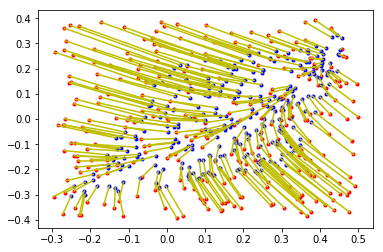

In [669]:
pe_net.SetTau(0.08)
pe_net.BackprojectExpectation(testtf[0])
yy = pe_net.Generate(1., testtf[0], dt=0.01)
#pe_net.Infer(1., testtf[1], testtf[0], dt=0.01)
#yy = pe_net.layers[0].v
y_true = testtf[0]
y = np.array([np.array(pe_net.layers[-1].sigma(k)) for k in yy])

n = 300
plt.plot(np.array(y_true[:n,0]), np.array(y_true[:n,1]), 'r.')
plt.plot(np.array(y[:n,0]), np.array(y[:n,1]), 'b.')
for k in range(n):
    st = [y_true[k,0], y[k,0]]
    en = [y_true[k,1], y[k,1]]
    plt.plot(st, en, 'y')

In [696]:
train_shuffle = list(zip(traintf[0],traintf[1]))
batch_size = 2
pe_net.learning_tau = torch.tensor(batch_size).float().to(device) * 5.
epochs = 200
fp = FloatProgress(min=0,max=epochs*len(train_shuffle))
display(fp)
pe_net.layers[1].Probe(False)
pe_net.learning_blackout = 1.
T = 2.
start_time = time.time()
for k in range(epochs):
    np.random.shuffle(train_shuffle)
    unzip = list(zip(*train_shuffle))
    batches = NN.MakeBatches(unzip[0], unzip[1], batch_size)
    for x in batches:
        #pe_net.Reset()
        pe_net.BackprojectExpectation(x[1])
        pe_net.Infer(T, x[1], x[0], learning=True)
        fp.value += batch_size
end_time = time.time()
print('Total time: '+str(end_time-start_time))

A Jupyter Widget

Allocating
Total time: 2518.108742952347


## Run the network

In [676]:
pe_net.Reset()
pe_net.ShowState()

Layer 0 (input):
  v = [0. 0.]
  e = [0. 0.]
Layer 1:
  v = [0. 0. 0. 0.]
  e = [0. 0. 0. 0.]
Layer 2 (expectation):
  v = [0. 0.]


In [635]:
pe_net.BackprojectExpectation(x[1])
pe_net.ShowState()

Allocating
Layer 0 (input):
  v = [[-0.00677532  0.15495285]
 [ 0.41394502  0.18223509]
 [ 0.14091754  0.15925536]
 [ 0.39819008  0.24159512]
 [ 0.23113787  0.04619613]]
  e = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Layer 1:
  v = [[ 0.3481825  -0.3079899  -0.06339662  0.26485574]
 [ 0.5146335  -1.2387946   0.17033422  1.516928  ]
 [ 0.39715198 -0.5929487   0.0080121   0.64887154]
 [ 0.68056935 -1.2353681   0.18171969  1.4533916 ]
 [ 0.12061188 -0.7092489   0.01535345  0.9105154 ]]
  e = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Layer 2 (expectation):
  v = [[-0.26991603  0.29078424]
 [ 0.43314663  0.14592792]
 [-0.05374738  0.2451123 ]
 [ 0.35253704  0.25747773]
 [ 0.17338844  0.02881639]]


In [677]:
pe_net.BackprojectExpectation(train1[0][0])
pe_net.layers[1].Probe(True)

In [674]:
pe_net.Generate(2., train1[0][0])

tensor([-0.1138, -0.2065])

In [678]:
pe_net.Infer(2., train1[1][0], train1[0][0])

In [544]:
pe_net.Reset()
pe_net.Generate(2., train1[0][0])

tensor([-0.1027, -0.1917])

Allocating


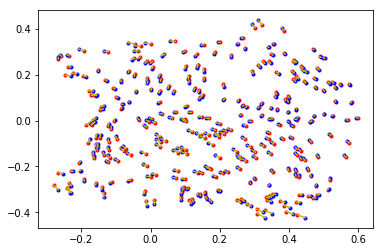

In [697]:
pe_net.Reset()
pe_net.SetTau(0.08)
yy = pe_net.Generate(4., testtf[0], dt=0.01)
y_true = testtf[1]
y = np.array([np.array(pe_net.layers[-1].sigma(k)) for k in yy])

n = 300
plt.plot(np.array(y_true[:n,0]), np.array(y_true[:n,1]), 'r.')
plt.plot(np.array(y[:n,0]), np.array(y[:n,1]), 'b.')
for k in range(n):
    st = [y_true[k,0], y[k,0]]
    en = [y_true[k,1], y[k,1]]
    plt.plot(st, en, 'y')

In [698]:
pe_net.Save('warp_2x4x2.npy')

In [492]:
pe_net = NN.NeuralNetwork()
pe_net.Load('warp_2x4x2.npy')

In [200]:
pe_net.Reset()
pe_net.Infer(2., train1[1][0], train1[0][0], learning=False)

In [201]:
print(train1[0][0])
print(pe_net.layers[-1].v)
print(Layer.identity(pe_net.layers[1].v))
print(pe_net.layers[0].v)

[-0.08027386 -0.30823911]
tensor([-0.0803, -0.3082])
tensor([-0.7056,  0.0506, -0.2264,  0.1358])
tensor([-0.0613, -0.2609])


In [202]:
pe_net.layers[1].e

tensor(1.00000e-03 *
       [-7.4737,  0.4279, -0.8380,  5.1968])

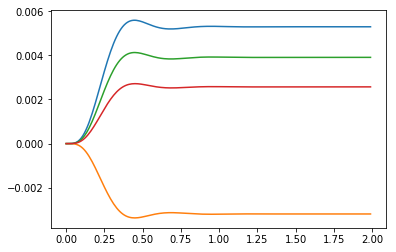

In [679]:
plt.plot(pe_net.t_history, pe_net.layers[1].e_history);

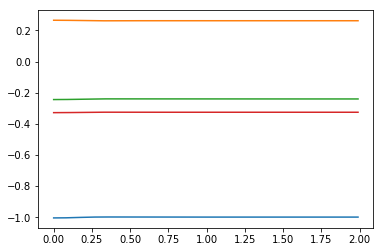

In [680]:
plt.plot(pe_net.t_history, pe_net.layers[1].v_history);